# Train GCN for Heat Stake Recognition

In [10]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [11]:
SEED = 60
EPOCHS = 50
LR = 0.004
DROPOUT = 0.3
VAL_SPLIT = 0.2
BATCH_SIZE = 12
WEIGHT_DECAY = 1e-4

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(torch.cuda.get_arch_list())
print(torch.cuda.is_available())
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


['sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90']
True
Using device: cuda


# Create Dataset

In [ ]:
import sys
import cadquery as cq
from pathlib import Path
import torch


BASE_DIR = Path.cwd().parent
if str(BASE_DIR) not in sys.path:
    sys.path.insert(0, str(BASE_DIR))
    
from preprocessing.graphs import build_brep_graph, nx_to_PyG

DATA_DIR = BASE_DIR / "GCN" / "training_data"
HEATSTAKE_DIR = DATA_DIR / "heatstakes"
OTHER_DIR = DATA_DIR / "other"
TEST_DIR = DATA_DIR / "test"
DATASET_FILE = BASE_DIR / "GCN" / "normalized_wodoor1_data_15_features.pt"
TEST_DATASET_FILE = BASE_DIR / "GCN" / "normalized_test_data_15_features.pt"

if True:
    dataset = []
    test_dataset = []

    def iter_step_files(folder: Path):
        return [p for p in folder.rglob('*') if p.suffix.lower() in {'.stp', '.step'}]

    possible_heatstakes = iter_step_files(HEATSTAKE_DIR)
    possible_others = iter_step_files(OTHER_DIR)
    tests = iter_step_files(TEST_DIR)

    print(f"Found {len(possible_heatstakes)} heatstake STEP files and {len(possible_others)} other STEP files.")
    for heatstake_path in possible_heatstakes:
        solids = cq.importers.importStep(str(heatstake_path)).faces()
        G = build_brep_graph(solids)
        data = nx_to_PyG([G])
        data[0].y = torch.tensor([1], dtype=torch.long)  # class 1 = heatstake
        dataset.append(data[0])
    for other_path in possible_others:
        solids = cq.importers.importStep(str(other_path)).faces()    
        G = build_brep_graph(solids)
        data = nx_to_PyG([G])
        data[0].y = torch.tensor([0], dtype=torch.long)  # class 0 = other
        dataset.append(data[0])
    
    print(f"Found {len(tests)} test STEP files.")
    for test_path in tests:
        solids = cq.importers.importStep(str(test_path)).faces()    
        G = build_brep_graph(solids)
        data = nx_to_PyG([G])
        if test_path.name.startswith("heatstake"):
            data[0].y = torch.tensor([1], dtype=torch.long)  # class 1 = heatstake
        else:
            data[0].y = torch.tensor([0], dtype=torch.long)  # class 0 = other
        test_dataset.append(data[0])

    # Shuffle the dataset
    rand_indices = torch.randperm(len(dataset))
    shuffled_dataset = [dataset[i] for i in rand_indices]

    torch.save(shuffled_dataset, DATASET_FILE)
    print(f"Saved dataset with {len(shuffled_dataset)} graphs to {DATASET_FILE}")

    torch.save(test_dataset, TEST_DATASET_FILE)
    print(f"Saved test dataset with {len(test_dataset)} graphs to {TEST_DATASET_FILE}")


c:\Users\A01369877\AppData\Local\miniconda3\envs\heatstakes\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found 150 heatstake STEP files and 150 other STEP files.
Saved dataset with 300 graphs to c:\Users\A01369877\Documents\GM\3d-part-localization\GCN\normalized_full_data_15_features.pt


# Load Dataset

In [12]:
# Load dataset (expects a single .pt file saved as a list of PyG Data objects)
from pathlib import Path

BASE_DIR = Path.cwd().parent
DATASET_FILE = BASE_DIR / "GCN" / "normalized_wodoor1_data_15_features.pt"
TEST_DATASET_FILE = BASE_DIR / "GCN" / "normalized_test_data_15_features.pt"

if DATASET_FILE.exists():
    dataset = torch.load(DATASET_FILE, weights_only=False)
    print(f"Loaded dataset with {len(dataset)} graphs from {DATASET_FILE}")
else:
    dataset = []
    print(f"Dataset file not found at {DATASET_FILE}. Add data or build dataset first.")
    
if TEST_DATASET_FILE.exists():
    test_dataset = torch.load(TEST_DATASET_FILE, weights_only=False)
    print(f"Loaded test dataset with {len(test_dataset)} graphs from {TEST_DATASET_FILE}")
else:
    test_dataset = []
    print(f"Test dataset file not found at {TEST_DATASET_FILE}. Add test data or build test dataset first.")

# Basic sanity check
if len(dataset) > 0:
    assert hasattr(dataset[0], 'x') and hasattr(dataset[0], 'edge_index') and hasattr(dataset[0], 'y'), \
        "Each Data must have x, edge_index, and y"
    print(f"First object: {dataset[0]}")
    print(f"Number of classes: {dataset[0].y.max().item() + 1}")
    print(f"Number of attributes: {dataset[0].x.size(-1)}")

Loaded dataset with 272 graphs from /home/mrestebato/Documents/Tec/7mo-semestre/ai/reto/3d-part-localization/GCN/normalized_wodoor1_data_15_features.pt
Loaded test dataset with 28 graphs from /home/mrestebato/Documents/Tec/7mo-semestre/ai/reto/3d-part-localization/GCN/normalized_test_data_15_features.pt
First object: Data(edge_index=[2, 1128], num_nodes=309, x=[309, 14], y=[1])
Number of classes: 2
Number of attributes: 14


# Per Graph Training

In [ ]:
labels = [int(d.y.item()) for d in dataset]
train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=VAL_SPLIT, random_state=SEED, stratify=labels if len(set(labels)) > 1 else None)
train_dataset = [dataset[i] for i in train_idx]
val_dataset = [dataset[i] for i in val_idx]

print(f"Train graphs: {len(train_dataset)} | Val graphs: {len(val_dataset)}")

In [ ]:
from GCN import GCN2

# Create model, criterion, optimizer (per-graph training)
if len(train_dataset) > 0:
    in_channels = train_dataset[0].x.size(-1)
    # model = GCN(feature_dim_size=in_channels, num_classes=2, dropout=DROPOUT).to(DEVICE)
    model = GCN2(feature_dim_size=in_channels).to(DEVICE)
    #criterion = nn.NLLLoss()
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

    #optimizer = optim.Adam(model.parameters(), lr=LR)
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    print(model)


In [ ]:
# Train/eval helpers

def train_one_epoch(model, dataset, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for data in dataset:
        data = data.to(DEVICE)
        optimizer.zero_grad()
        out = model(adj=data.edge_index, features=data.x)  # shape [1, 2]
        loss = criterion(out, data.y.long())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = out.argmax(dim=1)
        correct += int((preds == data.y).sum().item())
        total += data.y.size(0)

    avg_loss = total_loss / max(1, len(dataset))
    acc = correct / max(1, total)
    return avg_loss, acc


def evaluate(model, dataset, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataset:
            data = data.to(DEVICE)
            out = model(adj=data.edge_index, features=data.x)
            loss = criterion(out, data.y.long())
            total_loss += loss.item()
            preds = out.argmax(dim=1)
            correct += int((preds == data.y).sum().item())
            total += data.y.size(0)
    avg_loss = total_loss / max(1, len(dataset))
    acc = correct / max(1, total)
    return avg_loss, acc

In [ ]:
# Training loop with plots (per-graph, no DataLoader)
if (model is not None) and (len(train_dataset) > 0):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    for epoch in range(1, EPOCHS + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_dataset, optimizer, criterion)
        if len(val_dataset) > 0:
            vl_loss, vl_acc = evaluate(model, val_dataset, criterion)
        else:
            vl_loss, vl_acc = 0.0, 0.0

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(vl_loss)
        history["val_acc"].append(vl_acc)

        print(f"Epoch {epoch:03d} | Train Loss: {tr_loss:.4f} Acc: {tr_acc:.3f} | Val Loss: {vl_loss:.4f} Acc: {vl_acc:.3f}")

    # Plot loss and accuracy
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(history["train_loss"], label="train")
    axs[0].plot(history["val_loss"], label="val")
    axs[0].set_title("Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("NLLLoss")
    axs[0].legend()

    axs[1].plot(history["train_acc"], label="train")
    axs[1].plot(history["val_acc"], label="val")
    axs[1].set_title("Accuracy")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    plt.tight_layout()
    plt.show()
else:
    print("No dataset or model available. Build/load dataset and initialize model first.")

In [ ]:
# Run extra epochs if desired
EXTRA_EPOCHS = 30

for epoch in range(1, EXTRA_EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_dataset, optimizer, criterion)
    if len(val_dataset) > 0:
        vl_loss, vl_acc = evaluate(model, val_dataset, criterion)
    else:
        vl_loss, vl_acc = 0.0, 0.0

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(vl_loss)
    history["val_acc"].append(vl_acc)

    print(f"Epoch {epoch:03d} | Train Loss: {tr_loss:.4f} Acc: {tr_acc:.3f} | Val Loss: {vl_loss:.4f} Acc: {vl_acc:.3f}")

# Plot loss and accuracy
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(history["train_loss"], label="train")
axs[0].plot(history["val_loss"], label="val")
axs[0].set_title("Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("NLLLoss")
axs[0].legend()

axs[1].plot(history["train_acc"], label="train")
axs[1].plot(history["val_acc"], label="val")
axs[1].set_title("Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

## Metrics

In [ ]:
# Confusion Matrix on validation set (or train set if no val)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

def _collect_preds_targets(model, dataset):
    model.eval()
    ys, y_preds = [], []
    with torch.no_grad():
        for data in dataset:
            data = data.to(DEVICE)
            out = model(adj=data.edge_index, features=data.x)
            pred = out.argmax(dim=1).item()
            y_preds.append(pred)
            ys.append(int(data.y.item()))
    return np.array(ys), np.array(y_preds)

if (model is not None) and (len(train_dataset) > 0 or len(val_dataset) > 0):
    eval_set_name = "Validation" if len(val_dataset) > 0 else "Train"
    eval_set = val_dataset if len(val_dataset) > 0 else train_dataset

    y_true, y_pred = _collect_preds_targets(model, eval_set)

    labels = [0, 1]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["other", "heatstake"])
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(f"{eval_set_name} Confusion Matrix")
    plt.tight_layout()
    plt.show()

    try:
        print(f"\n{eval_set_name} Classification Report:")
        print(classification_report(y_true, y_pred, target_names=["other", "heatstake"]))
    except Exception as e:
        print("Could not generate classification report:", e)

# Batch Training

In [13]:
from torch_geometric.loader import DataLoader

labels = [int(d.y.item()) for d in dataset]
train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=VAL_SPLIT, random_state=SEED, stratify=labels if len(set(labels)) > 1 else None)
train_dataset = [dataset[i] for i in train_idx]
val_dataset = [dataset[i] for i in val_idx]

print(f"Train graphs: {len(train_dataset)} | Val graphs: {len(val_dataset)}")

graph_train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
graph_val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
graph_test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

batch = next(iter(graph_val_loader))
print("Batch:", batch)
print("Labels:", batch.y[:10])
print("Batch indices:", batch.batch)

Train graphs: 217 | Val graphs: 55
Batch: DataBatch(edge_index=[2, 12240], num_nodes=3351, x=[3351, 14], y=[12], batch=[3351], ptr=[13])
Labels: tensor([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])
Batch indices: tensor([ 0,  0,  0,  ..., 11, 11, 11])


In [14]:
from GCN import GCN3
from sklearn.utils.class_weight import compute_class_weight

in_channels = train_dataset[0].x.size(-1)
train_labels = [int(d.y.item()) for d in train_dataset]

model = GCN3(feature_dim_size=in_channels, dropout=DROPOUT).to(DEVICE)
weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=train_labels)
weights = torch.tensor(weights, dtype=torch.float).to(DEVICE)
#criterion = nn.CrossEntropyLoss(label_smoothing=0.05, weight=weights)
criterion = nn.CrossEntropyLoss(weight=weights)
#criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.6, patience=10)

print(model)

# Batch training helpers
def train_one_epoch_batch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch in loader:
        batch = batch.to(DEVICE)
        optimizer.zero_grad()
        
        # Forward pass with batch
        out = model(features=batch.x, adj=batch.edge_index, batch=batch.batch)
        loss = criterion(out, batch.y)
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch.num_graphs
        preds = out.argmax(dim=1)
        correct += int((preds == batch.y).sum().item())
        total += batch.num_graphs

    avg_loss = total_loss / max(1, total)
    acc = correct / max(1, total)
    return avg_loss, acc


def evaluate_batch(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(DEVICE)
            out = model(features=batch.x, adj=batch.edge_index, batch=batch.batch)
            loss = criterion(out, batch.y)
            
            total_loss += loss.item() * batch.num_graphs
            preds = out.argmax(dim=1)
            correct += int((preds == batch.y).sum().item())
            total += batch.num_graphs
    
    avg_loss = total_loss / max(1, total)
    acc = correct / max(1, total)
    return avg_loss, acc

GCN3(
  (conv1): GCNConv(14, 48)
  (conv2): GCNConv(48, 48)
  (conv3): GCNConv(48, 48)
  (fc1): Linear(in_features=96, out_features=48, bias=True)
  (out): Linear(in_features=48, out_features=2, bias=True)
)


## Training Loop

In [15]:
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch_batch(model, graph_train_loader, optimizer, criterion)
    
    if len(graph_val_loader) > 0:
        vl_loss, vl_acc = evaluate_batch(model, graph_val_loader, criterion)
    else:
        vl_loss, vl_acc = 0.0, 0.0

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(vl_loss)
    history["val_acc"].append(vl_acc)

    scheduler.step(vl_loss)
    curr_lr = optimizer.param_groups[0]["lr"]

    print(f"Epoch {epoch:03d} | Train Loss: {tr_loss:.4f} Acc: {tr_acc:.3f} | Val Loss: {vl_loss:.4f} Acc: {vl_acc:.3f}")

/home/mrestebato/.conda/envs/heatstakes/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 001 | Train Loss: 0.6796 Acc: 0.558 | Val Loss: 0.6250 Acc: 0.655
Epoch 002 | Train Loss: 0.5560 Acc: 0.728 | Val Loss: 0.3558 Acc: 0.909
Epoch 003 | Train Loss: 0.3851 Acc: 0.839 | Val Loss: 0.2423 Acc: 0.945
Epoch 004 | Train Loss: 0.2889 Acc: 0.894 | Val Loss: 0.1959 Acc: 0.909
Epoch 005 | Train Loss: 0.2623 Acc: 0.903 | Val Loss: 0.3300 Acc: 0.818
Epoch 006 | Train Loss: 0.3540 Acc: 0.903 | Val Loss: 0.2384 Acc: 0.927
Epoch 007 | Train Loss: 0.2719 Acc: 0.926 | Val Loss: 0.1745 Acc: 0.982
Epoch 008 | Train Loss: 0.2299 Acc: 0.931 | Val Loss: 0.1825 Acc: 0.945
Epoch 009 | Train Loss: 0.2300 Acc: 0.917 | Val Loss: 0.2618 Acc: 0.836
Epoch 010 | Train Loss: 0.2820 Acc: 0.926 | Val Loss: 0.1912 Acc: 0.927
Epoch 011 | Train Loss: 0.2621 Acc: 0.908 | Val Loss: 0.1843 Acc: 0.964
Epoch 012 | Train Loss: 0.1915 Acc: 0.940 | Val Loss: 0.1210 Acc: 0.982
Epoch 013 | Train Loss: 0.1583 Acc: 0.954 | Val Loss: 0.0942 Acc: 1.000
Epoch 014 | Train Loss: 0.2131 Acc: 0.935 | Val Loss: 0.1919 Acc

## Metrics

### Accuracy and Loss graphs

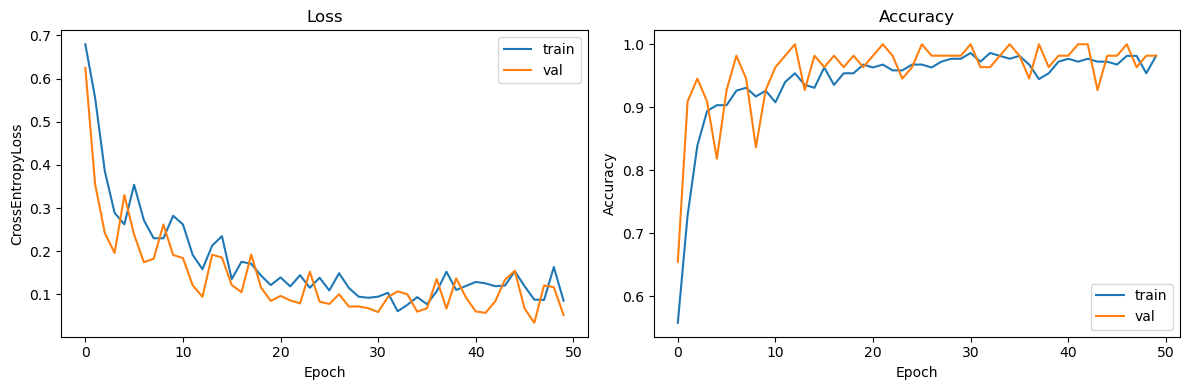

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(history["train_loss"], label="train")
axs[0].plot(history["val_loss"], label="val")
axs[0].set_title("Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("CrossEntropyLoss")
axs[0].legend()

axs[1].plot(history["train_acc"], label="train")
axs[1].plot(history["val_acc"], label="val")
axs[1].set_title("Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

### Confussion Matrix

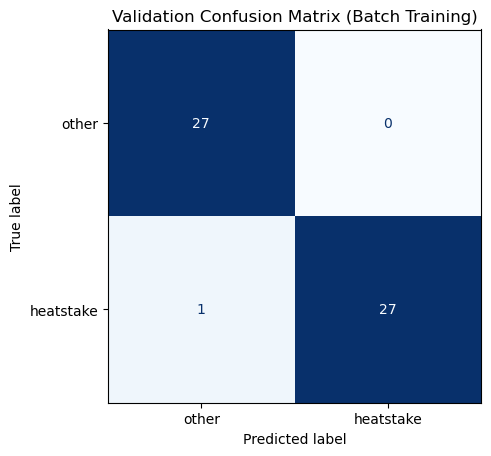


Validation Classification Report:
              precision    recall  f1-score   support

       other       0.96      1.00      0.98        27
   heatstake       1.00      0.96      0.98        28

    accuracy                           0.98        55
   macro avg       0.98      0.98      0.98        55
weighted avg       0.98      0.98      0.98        55



In [17]:
# Confusion Matrix for batch validation set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for batch in graph_val_loader:
        batch = batch.to(DEVICE)
        logits = model(features=batch.x, adj=batch.edge_index, batch=batch.batch)  # [G, 2]
        preds = logits.argmax(dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(batch.y.cpu().numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

labels = [0, 1]
cm = confusion_matrix(y_true, y_pred, labels=labels)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["other", "heatstake"])
disp.plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title("Validation Confusion Matrix (Batch Training)")
plt.tight_layout()
plt.show()

print("\nValidation Classification Report:")
print(classification_report(y_true, y_pred, target_names=["other", "heatstake"]))

In [9]:
torch.save(model.state_dict(), BASE_DIR / "GCN" / "good_heatstake_classifier.pth")